<a href="https://colab.research.google.com/github/tiaherdi/Traffic-Sign-5/blob/Siti-Khodijah-F-N-F/Air_Traffic_With_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
# IMPORT LIBRARY
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
# baca file dari drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#link traffic sign dataset
## https://docs.google.com/spreadsheets/d/1zQb3J5oARglZ2zP9lxLa-S2QqVFk_z1g78UVaY88eLI/edit#gid=0&range=C7

In [4]:
#Reads in Air Traffic csv 
dataset=pd.read_csv('/content/drive/MyDrive/covid_impact_on_airport_traffic.csv',index_col='Date',parse_dates=['Date'])

In [5]:
# Feature selection -> mengambil data yang dibutuhkan
data = dataset.drop(['AggregationMethod', 'Version', 'ISO_3166_2', 'Geography', 'Centroid', 'AirportName', 'State', 'City'], 
                         axis=1)
data = data.sort_values(by="Date")
data.head()

,PercentOfBaseline,Country
Date,,
2020-03-16,96,Chile
2020-03-16,72,Canada
2020-03-16,92,United States of America (the)
2020-03-16,98,United States of America (the)
2020-03-16,68,United States of America (the)


In [6]:
# membuat dataframe per negara
data_per_negara = data.groupby('Country')
australia = data_per_negara.get_group('Australia')
canada = data_per_negara.get_group('Canada')
chile = data_per_negara.get_group('Chile')
us  = data_per_negara.get_group('United States of America (the)')

In [7]:
chile.head()

,PercentOfBaseline,Country
Date,,
2020-03-16,96,Chile
2020-03-17,72,Chile
2020-03-18,56,Chile
2020-03-19,52,Chile
2020-03-20,53,Chile


In [8]:
baseline=chile.PercentOfBaseline.sort_index()
baseline

Date
2020-03-16    96
2020-03-17    72
2020-03-18    56
2020-03-19    52
2020-03-20    53
              ..
2020-11-27    48
2020-11-28    39
2020-11-30    65
2020-12-01    45
2020-12-02    48
Name: PercentOfBaseline, Length: 238, dtype: int64

In [9]:
#start dataset at 2020-03-16 and ends in 2020-12-02
start = pd.to_datetime('2020-03-16')
end = pd.to_datetime('2020-12-02')
baseline = baseline[start:end]
print('Sample of Time Series Data:')
baseline.head()

Sample of Time Series Data:


Date
2020-03-16    96
2020-03-17    72
2020-03-18    56
2020-03-19    52
2020-03-20    53
Name: PercentOfBaseline, dtype: int64

Impute Missing Dates

In [10]:
x = pd.date_range(start='2020-03-16', end='2020-12-02', freq="D") #continous dates
y = baseline.index #the time series
diff_dates= x.difference(y) #find what in 'x' not in 'y'

td= pd.Timedelta(1, 'd') # 1 day
for date in diff_dates:
  prev_val = baseline[date-td] #ambil nilai sebelumnya
  baseline[date] = prev_val # buang nilai sebelumnya

baseline.sort_index(inplace=True)
#set time index freq as daily
baseline.freq="D"

<function matplotlib.pyplot.show>

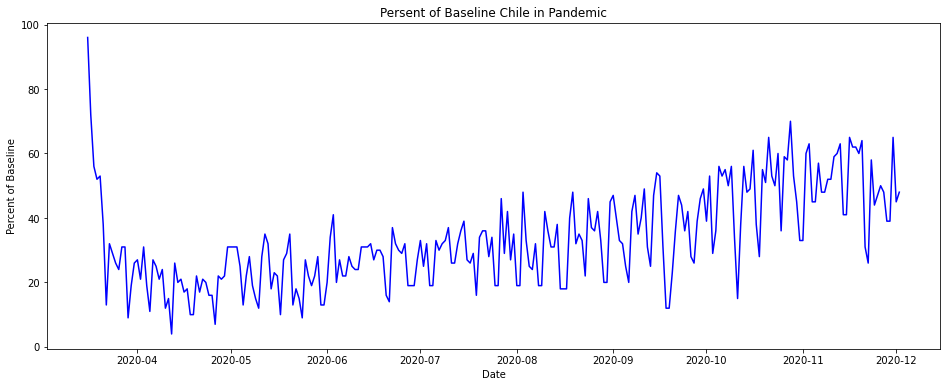

In [11]:
#displays plot of baseline
fig= plt.figure(figsize=(16,6))
plt.plot(baseline, color='blue')
plt.xlabel('Date')
plt.ylabel('Percent of Baseline')
plt.title("Persent of Baseline Chile in Pandemic")
plt.show

Split Data for Training and Testing

In [12]:
split_time = int(0.8 * len(baseline))

train = baseline[:split_time]
test = baseline[split_time:]

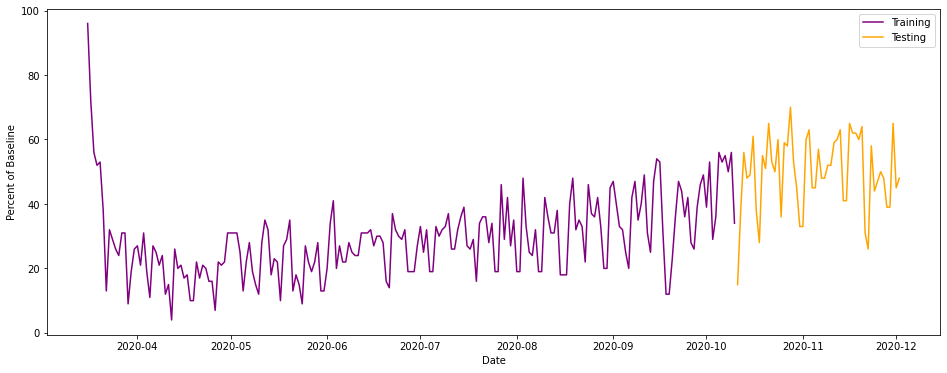

In [13]:
#display a plot of train and test split
fig = plt.figure(figsize=(16,6))
plt.plot(train, color='purple', label='Training')
plt.plot(test, color='orange', label='Testing')
plt.xlabel('Date')
plt.ylabel('Percent of Baseline')
plt.legend()
plt.show()

In [33]:
#Creates a windowed dataset from the time series data
WINDOW = 20 #the window value... 14 days

#converts values to TensorSliceDataset
train_data = tf.data.Dataset.from_tensor_slices(train.values) 

#takes window size + 1 slices of the dataset
train_data = train_data.window(WINDOW+1, shift=1, drop_remainder=True)

#flattens windowed data by batching 
train_data = train_data.flat_map(lambda x: x.batch(WINDOW+1))

#creates features and target tuple
train_data = train_data.map(lambda x: (x[:-1], x[-1]))

#shuffles dataset
train_data = train_data.shuffle(1_000)

#creates batches of windows
train_data = train_data.batch(32).prefetch(1)

In [34]:
from tensorflow.keras.callbacks import Callback

class CustomCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('mae') < 10.0:
            print("MAE under 10.0... Stopping training")
            self.model.stop_training = True

my_callback = CustomCallback()

In [35]:
from tensorflow.keras.callbacks import LearningRateScheduler

#creates a function that updates the learning rate based on the epoch number
def scheduler(epoch, lr):
    if epoch < 2:
        return 0.01
    else:
        return lr * 0.99

lr_scheduler = LearningRateScheduler(scheduler)

Build the Model

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, LSTM, Dropout, Lambda, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber

mixed_model = Sequential([
    # add extra axis to input data
    Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[WINDOW]), Conv1D(filters=64, kernel_size=3, strides=1,
           padding='causal', activation='relu'),
    Bidirectional(LSTM(128, return_sequences=True)),
    Bidirectional(LSTM(128)),
    Dropout(0.3),
    Dense(512, activation='relu'),
    Dropout(0.4),
    Dense(1)
])

In [37]:
mixed_model.compile(
    loss=Huber(),
    optimizer=Adam(),
    metrics=['mae']
)

mixed_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_4 (Lambda)           (None, 20, 1)             0         
                                                                 
 conv1d_2 (Conv1D)           (None, 20, 64)            256       
                                                                 
 bidirectional_4 (Bidirectio  (None, 20, 256)          197632    
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 512)              

In [38]:
#Trains Mixed Model
mixed_history = mixed_model.fit(
    train_data,
    epochs=30,
    callbacks=[lr_scheduler, my_callback],
    verbose=0
)

MAE under 10.0... Stopping training


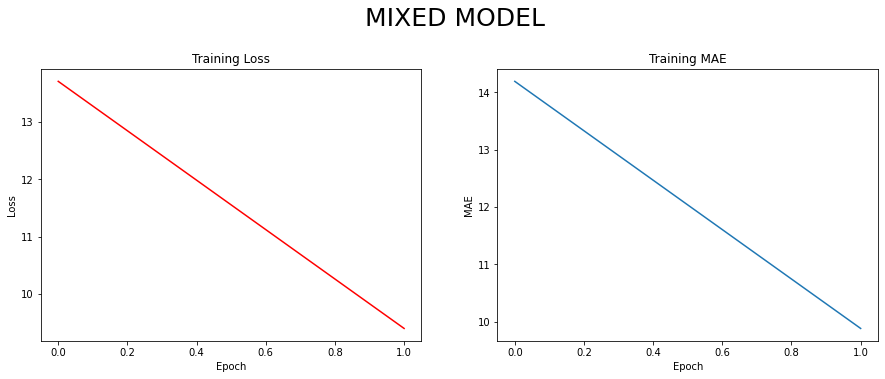

					FINAL LOSS: 9.4 | FINAL MAE: 9.88


In [32]:
#plots training history
#Plots history of model training
plt.rcParams["figure.figsize"] = (15,5)
fig, axs = plt.subplots(1, 2)

axs[0].plot(mixed_history.history['loss'], color='red')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training Loss')

axs[1].plot(mixed_history.history['mae'])
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('MAE')
axs[1].set_title('Training MAE')

fig.text(0.425,1, 'MIXED MODEL', {'size':25})
plt.show()

print("\t\t\t\t\tFINAL LOSS: {} | FINAL MAE: {}".format(
                                                round(mixed_history.history['loss'][-1], 2),
                                                 round(mixed_history.history['mae'][-1], 2)))


Forecast Data

In [39]:
#chunck of data to be windowed so that each window associated to a value in test set
forecast_data = train[-WINDOW:].append(test[:-1]).values

In [48]:
model_forecasts = {'MIXED MODEL': []}

#converts values to TensorSliceDataset
test_data = tf.data.Dataset.from_tensor_slices(forecast_data) 
    #takes window size  slices of the dataset
test_data = test_data.window(WINDOW, shift=1, drop_remainder=True)
    #flattens windowed data by batching 
test_data = test_data.flat_map(lambda x: x.batch(WINDOW+1))
    #creates batches of windows
test_data = test_data.batch(32).prefetch(1)
    #gets model prediction 
preds = mixed_model.predict(test_data)
    #append to forecast dict
model_forecasts['MIXED MODEL'].append(preds)

In [51]:
N = test.values.shape[0] #number of samples in test set
mix_mae = np.abs(test.values - model_forecasts['MIXED MODEL'][0].squeeze()).sum() / N
print('MIXED MAE:', round(mix_mae, 2))

MIXED MAE: 16.88


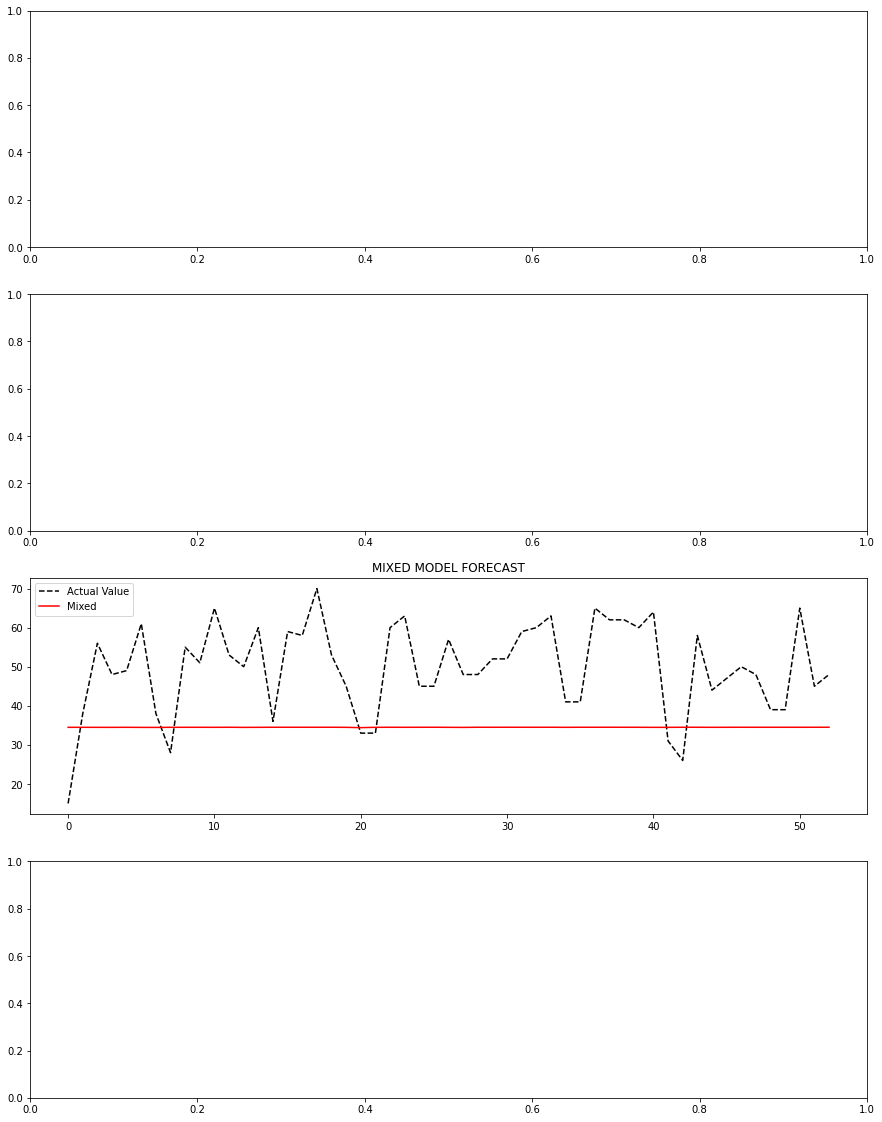

In [52]:
#displays forecasted data
plt.rcParams["figure.figsize"] = (15,20)
fig, axs = plt.subplots(4, 1)

#Mixed Model Forecast
axs[2].plot(test.values, color='black', linestyle='--', label='Actual Value')
axs[2].plot(model_forecasts['MIXED MODEL'][0].squeeze(), color='red', label='Mixed')
axs[2].set_title('MIXED MODEL FORECAST')
axs[2].legend()